# Testing

In [1]:
# Global Import
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

# Local imports
# from testers import single_robot_multiple, single_robot_single
# from testers.helpers import imshow, get_random_coords, is_valid, is_bounded, get_area_map, get_all_area_maps
# from testers.helpers import imshow, generate_no_obs_area_map, generate_point_obstacles

from cpp_algorithms.testers import single_robot_multiple, single_robot_single
from cpp_algorithms.testers import imshow, get_random_coords, is_valid, is_bounded, get_area_map, get_all_area_maps
from cpp_algorithms.testers import imshow, generate_no_obs_area_map, generate_point_obstacles

from cpp_algorithms.fuel_path.constants import OB, NO
from cpp_algorithms.fuel_path.fuel_path import splice_paths, get_fuel_paths
from cpp_algorithms.fuel_path.dist_matrix import dist_fill

/Users/alan/Desktop/stuff/SIH/nm_383_cpp/cpp_algorithms/testers/testers.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Helpers

In [3]:
# Constants
AMS_PATH = "./test_maps/" # Area Maps Paths

## Testing Fuel Distance Map Generations

**Fuel Distance maps** generated from all the **area maps**
in the `test_maps` folder.  
Black points : Fuel

/Users/alan/Desktop/stuff/SIH/nm_383_cpp/cpp_algorithms/testers/helpers.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


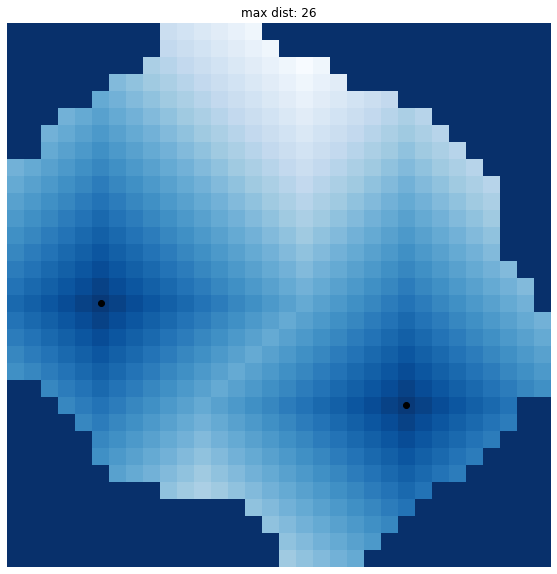

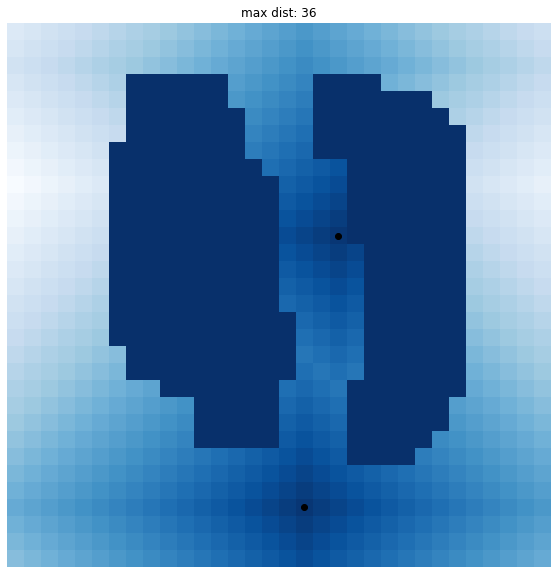

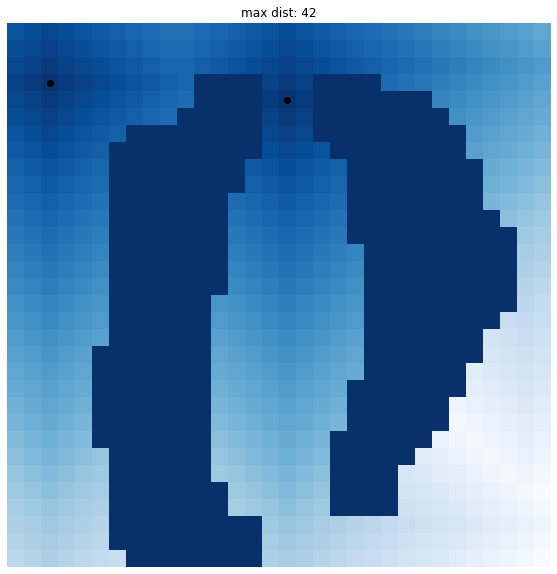

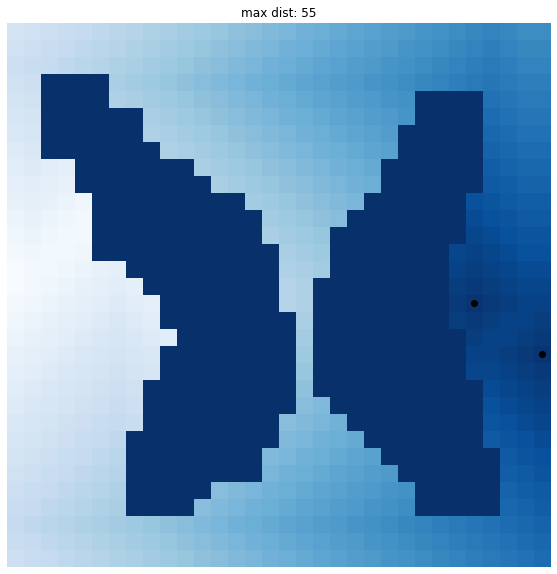

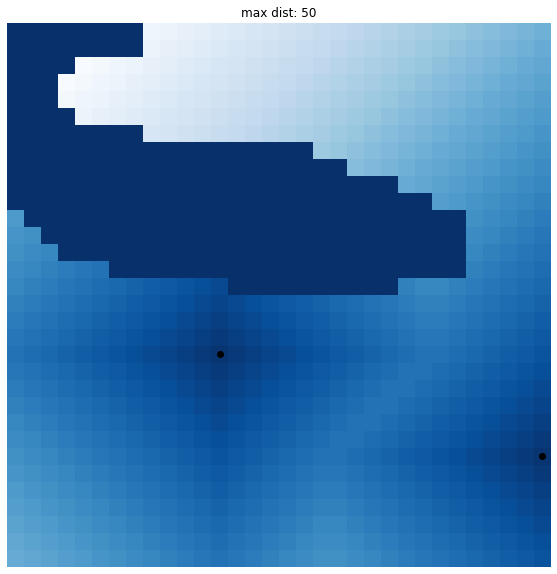

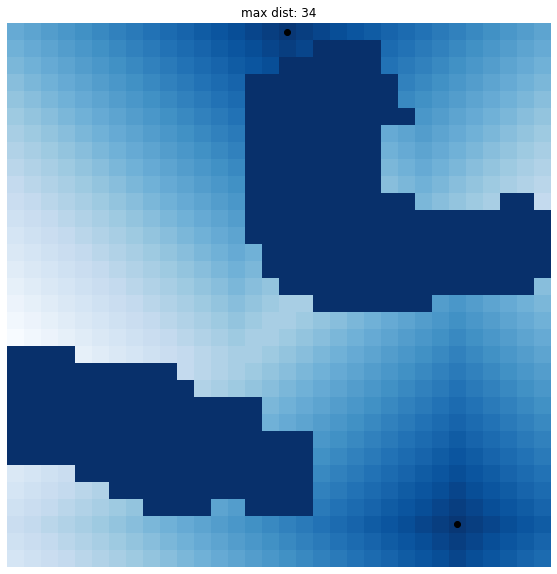

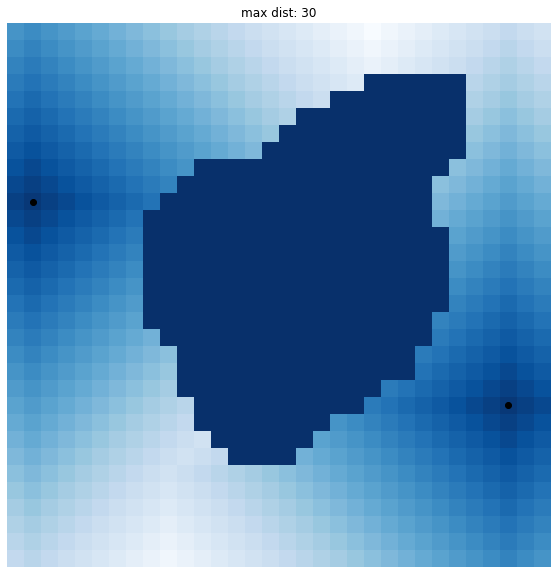

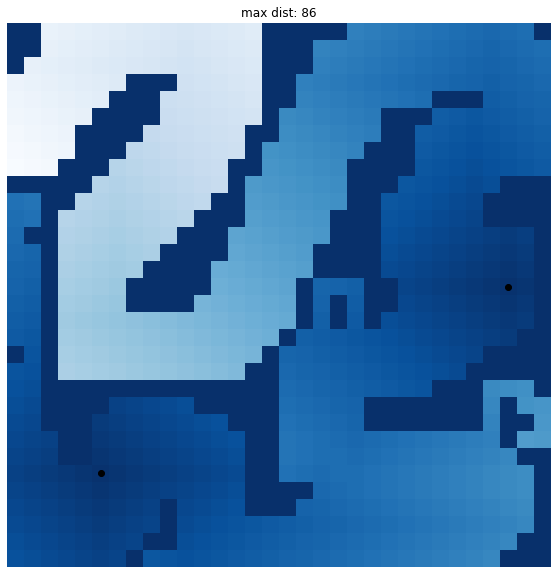

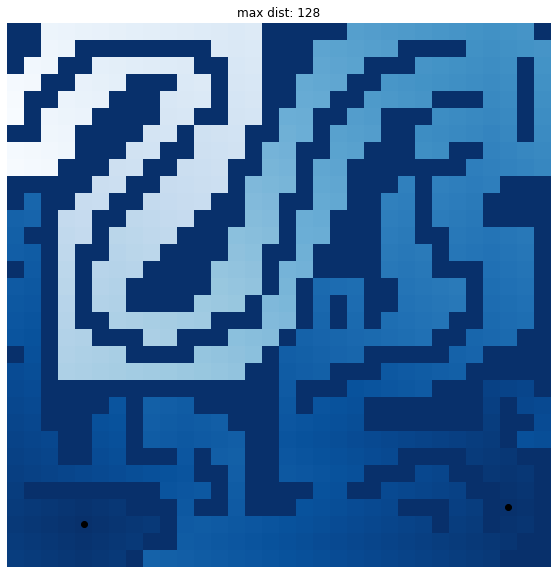

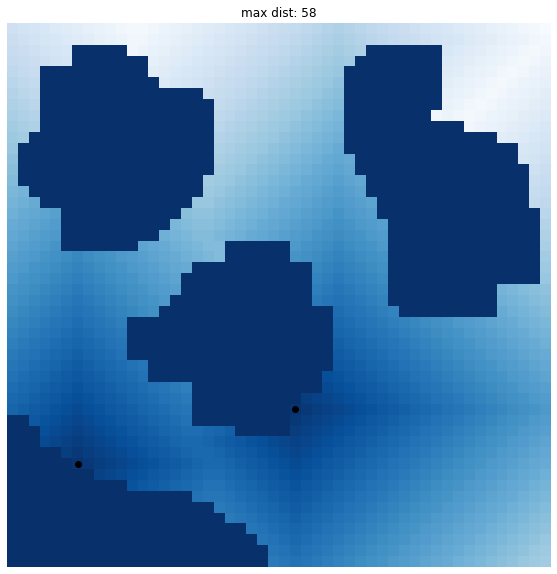

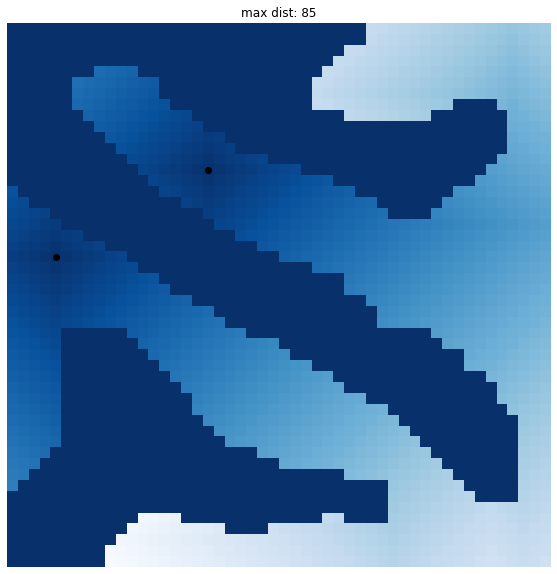

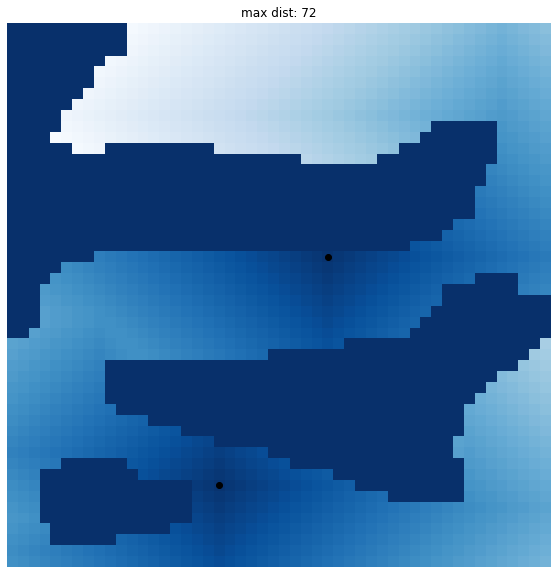

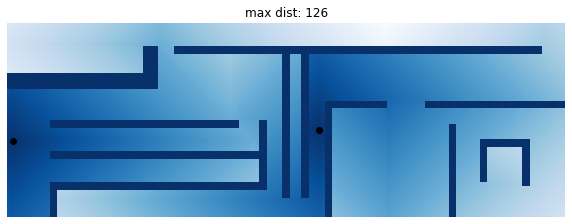

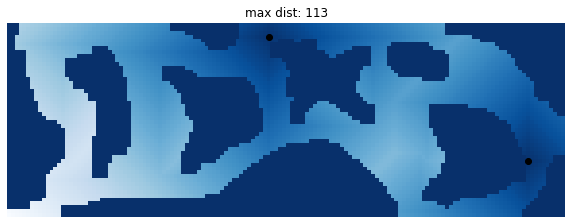

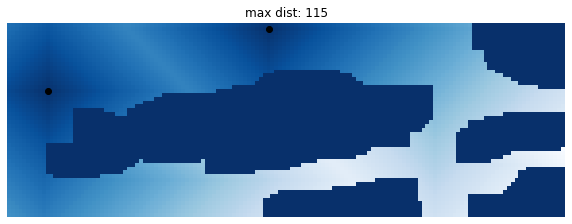

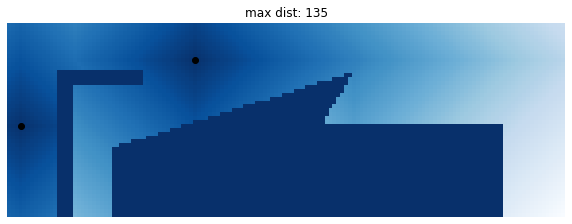

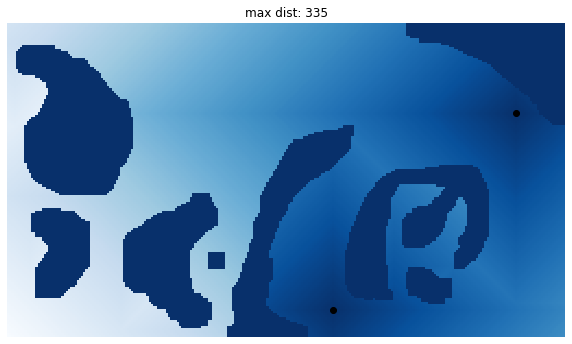

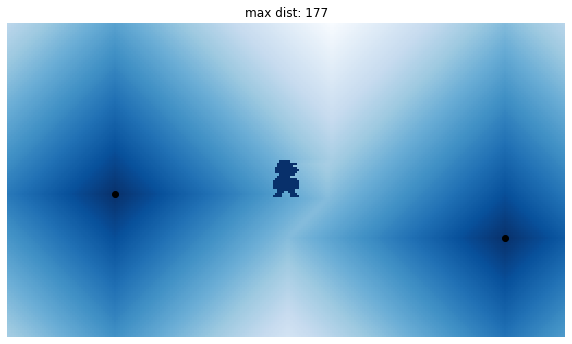

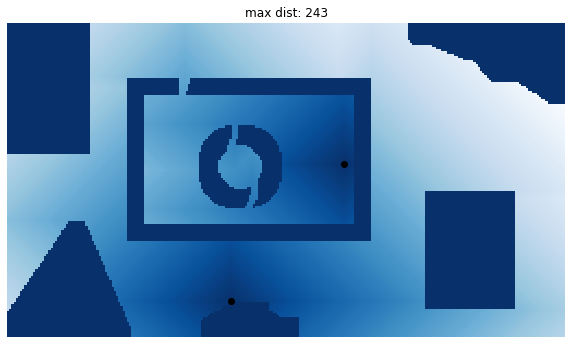

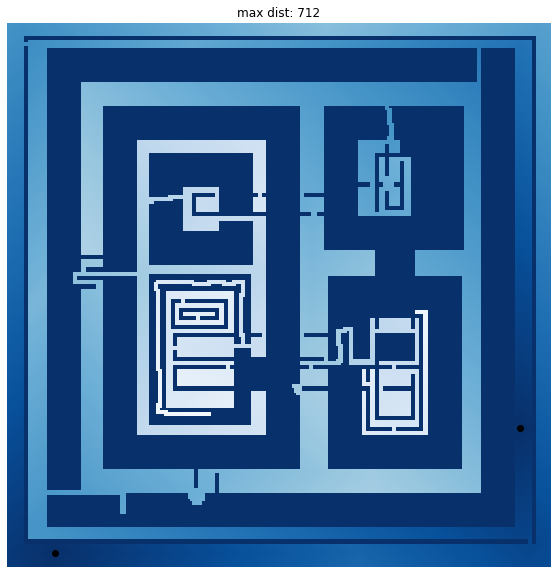

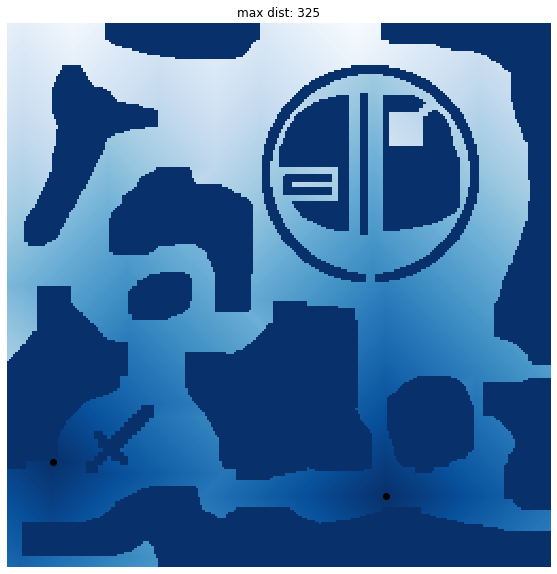

In [4]:
area_maps = get_all_area_maps("./test_maps")
for am in area_maps:
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Blues_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

**Fuel Distance maps** generated from **point obstacles** added to no obstacle maps.  
Black points : Fuel

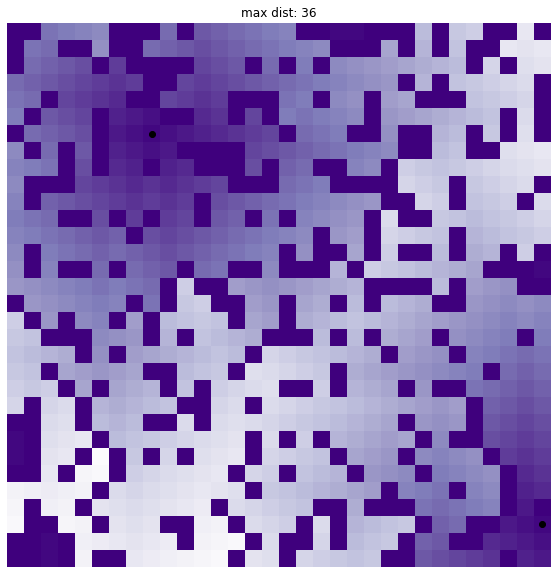

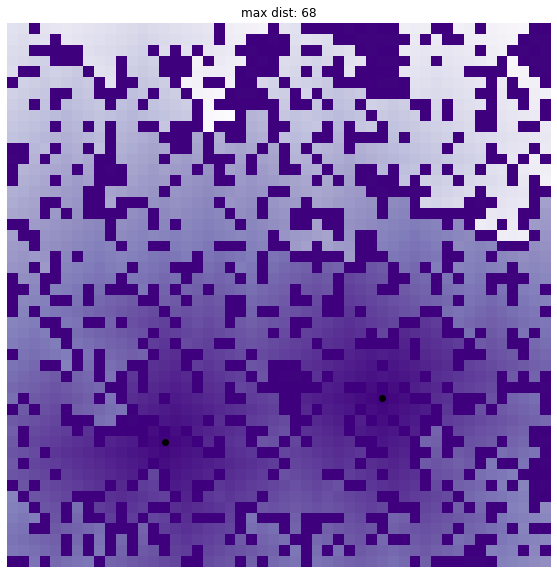

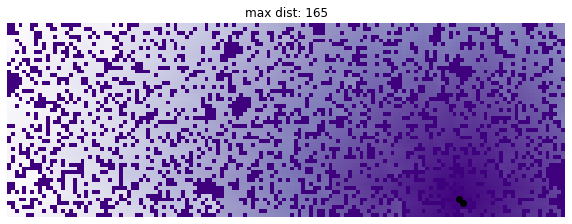

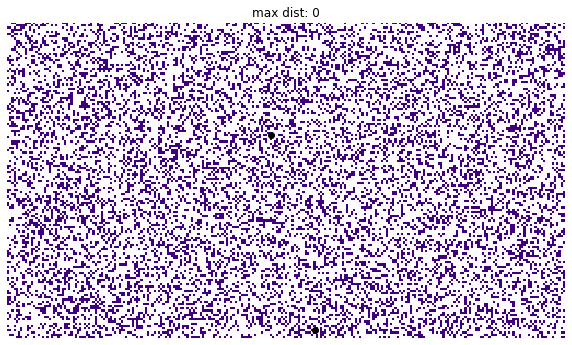

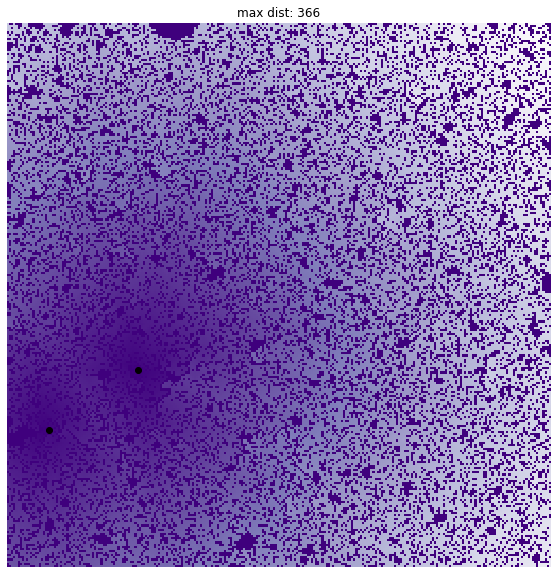

In [5]:
for am_ in generate_no_obs_area_map():
    am = generate_point_obstacles(am_, p=0.3)
    fp = get_random_coords(am)
    dm  = dist_fill(am, fp,)
    imshow(dm,(10,10),cmap="Purples_r")
    x,y = np.array(fp).T
    plt.scatter(y,x, c="black")
    plt.title(f"max dist: {dm.max()}")

## Dummy path generator

This needs to be replaced with the actual algorithms.

In [7]:
def get_next_point(dist_map, point, v_map):
    x,y = point
    points_ = [(x,y+1),(x,y-1),(x-1,y),(x+1,y)]
    sh = dist_map.shape
    
    max_ = -1
    d_vals = []
    v_vals = []
    
    points = []
    for p in points_:
        if is_bounded(p, sh) and dist_map[p] != OB:
            points.append(p)
            v_vals.append(v_map[p])
            d_vals.append(dist_map[p])
        
    d_vals = np.array(d_vals)
    v_vals = ~np.array(v_vals) # Not visited : True
    
    if v_vals.sum() == 0:
        return points[d_vals.argmin()]
    else:
        where = np.where(v_vals)[0]
        idx = where[d_vals[where].argmax()]
        return points[idx]

def traversal_path(dist_map, start):
    """
    dist_map : map of distances to the end
    start : (x,y) of the robot
    
    Assumption : end has value 0 and only
        a single end is present
    """
    shape = dist_map.shape
    v_map = (dist_map == OB).copy()
    end = tuple(np.array(np.where(dist_map==0)).flatten())
    
    point = start
    path = []
    try:
        while (~v_map).sum() > 0:
            path.append(point)
            v_map[point]  = True
            if point == end:
                break

            point = get_next_point(dist_map, point, v_map)
    except:
        return path
    return path

def dummy_coverage(area_map, start_point, end_point):
    """
    area_map : map pertaining to the area
    start_point : (x,y) where the drone starts cpp from
    end_point : (x,y) where the drone ends cpp at
    """
    assert is_valid(start_point, area_map), "invalid start"
    assert is_valid(end_point, area_map), "invalid end"
    
    dist_map = dist_fill(area_map, [end_point])
    return traversal_path(dist_map, start_point)

## Run Tests

In [8]:
# Required for animations.
# Don't forget to close the figure.
%matplotlib notebook 

### Single Robot Tests

Running the tests on multiple area maps, the first 10 in the folder.

In [9]:
single_robot_multiple(dummy_coverage, area_maps[:10])

,cp_compute_time,fp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape,fuel_path_len,fuel_capacity,max_dist_fuel
0,0.034258,0.007127,716,308,669,678,0.934358,0.013274,"(32, 32)",196,185,37
1,0.021304,0.007111,689,335,682,717,0.989840,0.048815,"(32, 32)",76,205,41
2,0.024842,0.005925,639,385,635,679,0.993740,0.064801,"(32, 32)",132,270,54
3,0.015511,0.006500,654,370,649,696,0.992355,0.067529,"(32, 32)",152,250,50
4,0.017636,0.004060,794,230,790,809,0.994962,0.023486,"(32, 32)",160,345,69
5,0.016979,0.009912,725,299,724,779,0.998621,0.070603,"(32, 32)",186,210,42
6,0.022170,0.004014,723,301,691,720,0.955740,0.040278,"(32, 32)",206,275,55
7,0.020535,0.013387,772,252,752,824,0.974093,0.087379,"(32, 32)",80,250,50
8,0.014536,0.009766,610,414,565,723,0.926230,0.218534,"(32, 32)",14,455,91
9,0.057596,0.018014,1529,971,1505,1568,0.984303,0.040179,"(50, 50)",316,265,53


Running the test on a single area map with the animation.

<IPython.core.display.Javascript object>


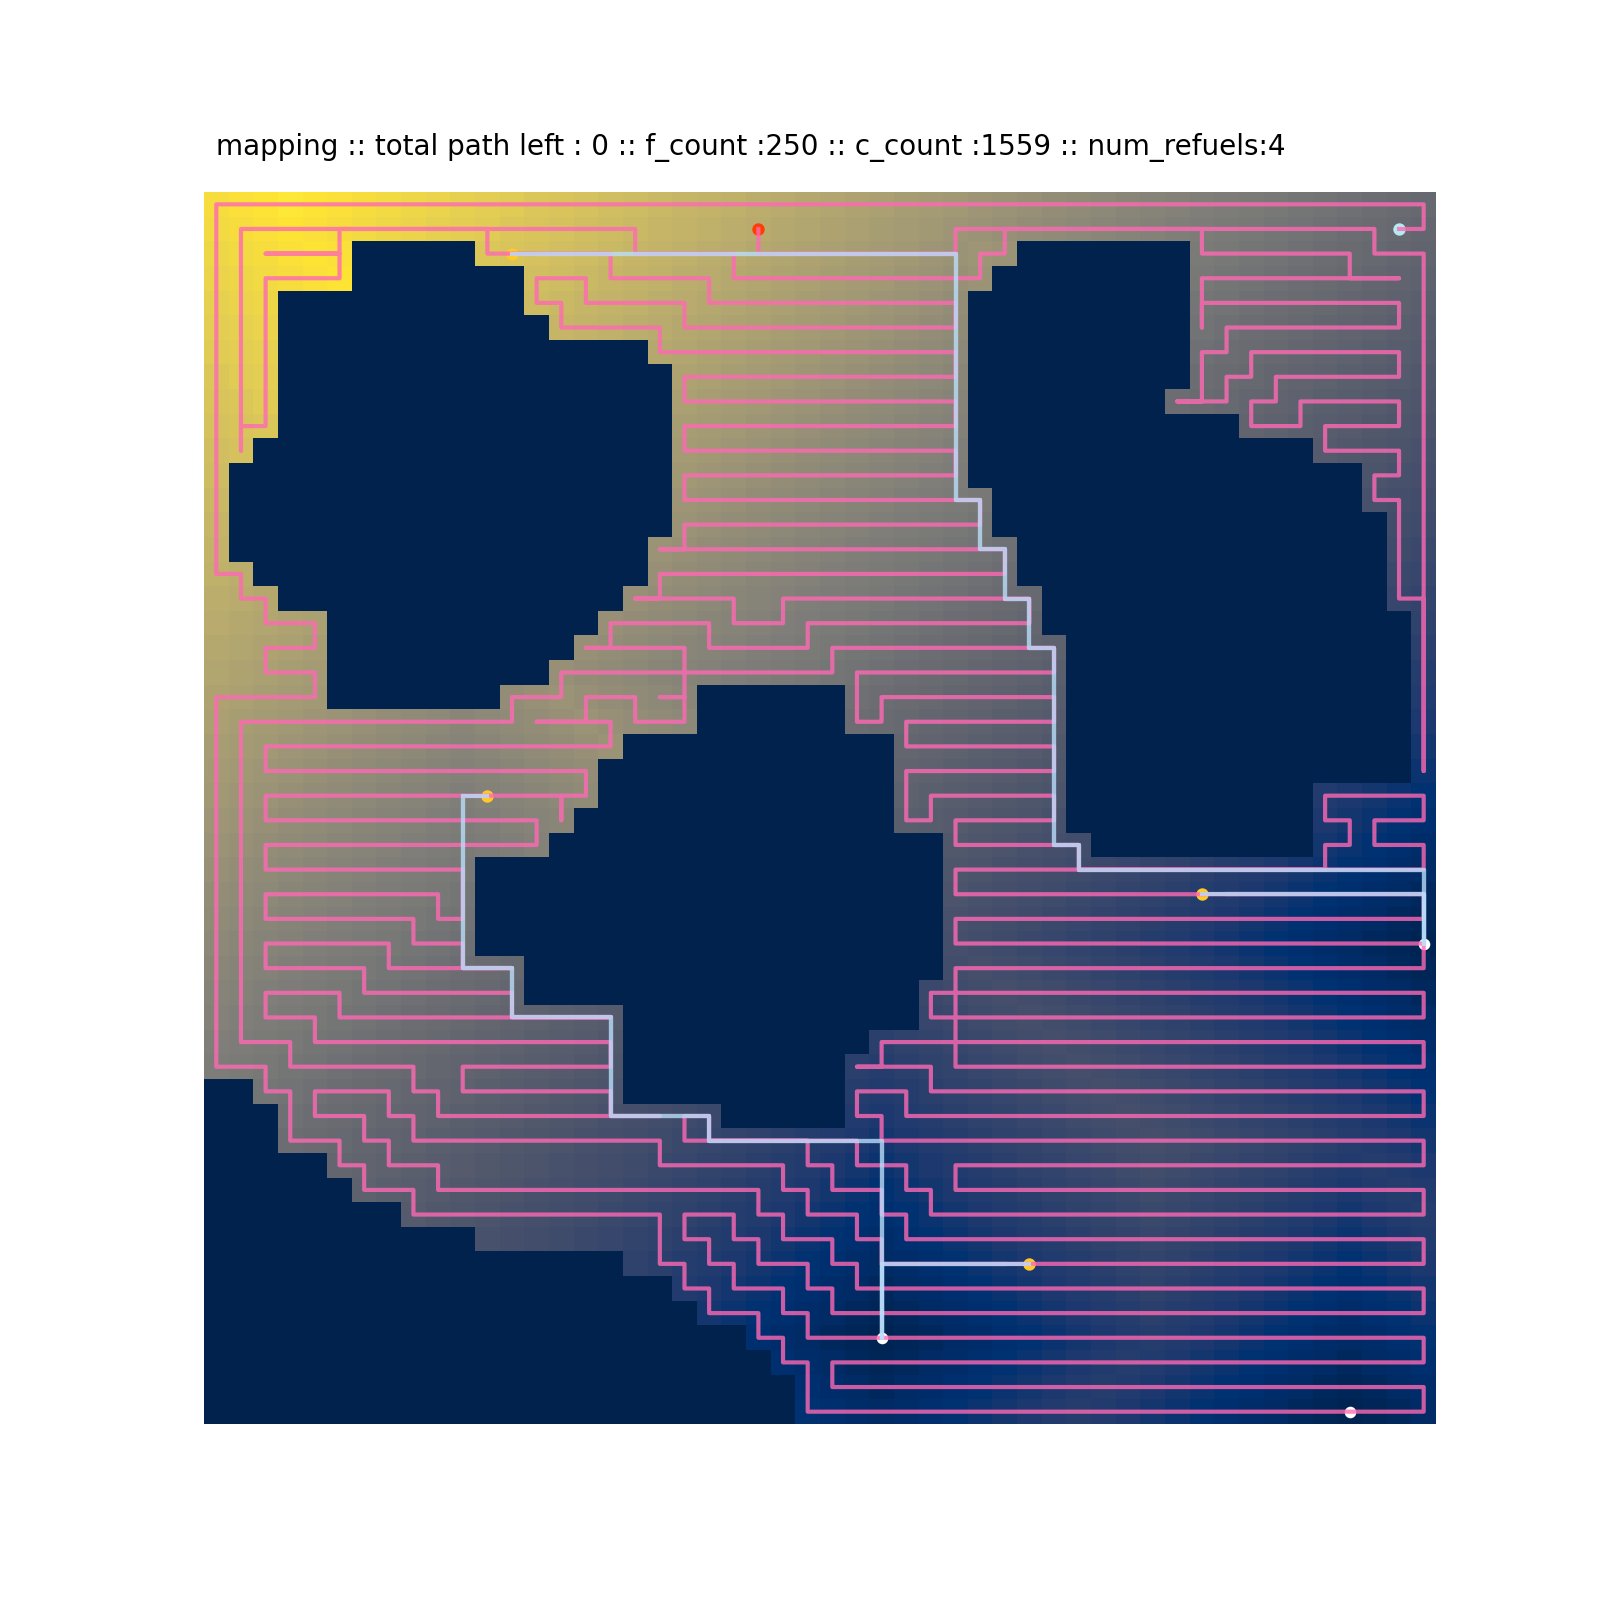

     cp_compute_time : 0.05759286880493164
     fp_compute_time : 0.024615049362182617
     points_to_visit : 1529
     obstacle_points : 971
      points_visited : 1492
   coverage_path_len : 1559
            coverage : 0.9758011772400261
          redundancy : 0.04297626683771649
          area_shape : (50, 50)
       fuel_path_len : 258
       fuel_capacity : 380
       max_dist_fuel : 76


In [10]:
metrics, _ = single_robot_single(dummy_coverage, area_maps[9], animate=True, interval=1)

# ToDo

## Path generation API
### Single Robot Path Generation
- Generate coverage path from given area map and list of relevant points (start, end, fuel).✅
- Generate fuel path from given fuel map and coverage path.✅
- Generate combined path.✅

### Multiple Robot Path Generation
- Obtain area division map from DARP.
- Pass area division map to all algos with relevant cell value to represent mapping area.
- Same interface as single robot path generation.

## Testing
### Functions to visualize
- Animation single robot✅
- Animation multiple robots
- Map Show single robot✅
- Map show multiple robots


### Metrics
- Single Robot✅
- Multiple Robots✅
#### Percents
- **Coverage** - Percentage of non obstacle cells covered by the path.✅
- **Redundancy** - Percentage of cells from the path that have been revisited (backtracked).✅

#### Timings
- **Coverage Path computation time** - Time taken by the algorithm to compute the coverage path.✅
- **Fuel Path computation time** - Time taken to compute the refuel path.✅

#### Numbers
- **Coverage cells** - Number of cells to be covered.✅
- **Non covered cells** - Cells that haven't been covered.✅
- **Backtrack** - Count of coverage path cells that have been revisited.✅
- **Coverage Path length** - Number of steps in the area coverage path.✅
- **Fuel Path length** - Number of steps in the refueling path.✅
    
### Running Tests On/Create maps for
- Resolutions, Get obstacle maps of the following resolutions.✅
    - (32, 32)✅
    - (50, 50)✅
    - (144, 50)✅
    - (256, 144)✅
    - (256, 256)✅
- Obstacle types
    - None✅
    - Point obstacles (single cell obstacles generated randomly).✅
    - Region obstacles (region obstacles that have been painted).✅
        - Corners✅
        - Central✅
        - Caves✅
        - Pipes, Bottlenecks✅
    - Combination of both.✅